In [5]:
import pandas as pd
import numpy as np

# ================================================================
# 2️⃣ GENERATE SYNTHETIC SUPPLY CHAIN DATA
# ================================================================
n_samples = 2000
seq_len = 30
n_features = 10

# Generate features
dates = pd.date_range("2023-01-01", periods=n_samples, freq="D")
regions = np.random.choice(["North", "South", "East", "West"], size=n_samples)
weather = np.random.choice(["Sunny", "Rainy", "Snowy", "Cloudy"], size=n_samples)
seasonality = np.sin(np.linspace(0, 4 * np.pi, n_samples))
promotion = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
price = 100 + np.random.randn(n_samples) * 5
discount = np.random.uniform(0, 0.3, n_samples)
competitor_price = price + np.random.randn(n_samples) * 3
inventory_lag = np.random.randint(300, 500, n_samples)

# True demand pattern (depends on features)
base_demand = 120 + 10 * seasonality - 0.5 * price + 15 * promotion
true_demand = base_demand + np.random.randn(n_samples) * 3
true_demand = np.maximum(true_demand, 10)

# DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Region": regions,
    "Weather": weather,
    "Seasonality": seasonality,
    "Promotion": promotion,
    "Price": price,
    "Discount": discount,
    "CompetitorPrice": competitor_price,
    "InventoryLag": inventory_lag,
    "TrueDemand": true_demand,
})

print("🧩 Synthetic dataset created:", df.shape)
df.head()
df.to_csv("SyntheticSupplyChain.csv")

import pickle
import json

# --- 1. Save the forecaster's Y-scaler ---
# We save the mean and std, which is all the 'scaler_y.pkl' was.
scaler_y_data = {
    'mean': y_mean,
    'std': y_std
}

with open("forecaster_scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y_data, f)

print("✅ Saved forecaster_scaler_y.pkl")

# --- 2. Save the forecaster's feature list ---
# We need this to make sure the API processes data in the correct order.
# 'feature_cols' was defined just before create_sequences.
with open("forecaster_features.json", "w") as f:
    json.dump(feature_cols, f)
    
print("✅ Saved forecaster_features.json")

🧩 Synthetic dataset created: (2000, 10)
✅ Saved forecaster_scaler_y.pkl
✅ Saved forecaster_features.json


In [4]:
# One-hot encode and ensure numeric
df_encoded = pd.get_dummies(df, columns=["Region", "Weather"], drop_first=True)
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce').fillna(0.0)

feature_cols = [c for c in df_encoded.columns if c not in ["Date", "TrueDemand"]]
X_all = df_encoded[feature_cols].values
y_all = df_encoded["TrueDemand"].values

# Sequence creation
def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

X_seq, y_seq = create_sequences(X_all, y_all, seq_len)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Normalize targets for stability (demand ~0–2)
y_mean, y_std = y_train.mean(), y_train.std()
y_train_n = (y_train - y_mean) / y_std
y_test_n = (y_test - y_mean) / y_std

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_n, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_n, dtype=torch.float32, device=device)


NameError: name 'torch' is not defined

In [ ]:
# ================================================================
# 4️⃣ DIFFERENTIABLE QP OPTIMIZATION LAYER
# ================================================================
n_warehouses, n_transports = 6, 4
n_candidates = n_warehouses * n_transports

x = cp.Variable(n_candidates, nonneg=True)
c_param = cp.Parameter(n_candidates)
d_param = cp.Parameter(1)
cap_param = cp.Parameter(n_candidates)

eps = 1e-2
objective = cp.Minimize(c_param @ x + (eps/2) * cp.sum_squares(x))
A = np.ones((1, n_candidates))
constraints = [A @ x >= d_param, x <= cap_param]
prob = cp.Problem(objective, constraints)
qp_layer = CvxpyLayer(prob, parameters=[c_param, d_param, cap_param], variables=[x])

def gen_costs(batch_size):
    base = torch.linspace(10, 30, n_candidates, device=device)
    noise = torch.randn(batch_size, n_candidates, device=device)
    return base + noise

def gen_caps(batch_size):
    return torch.ones(batch_size, n_candidates, device=device) * 1000.0

In [ ]:
# ================================================================
# 4️⃣ TRAINING — STAGE 1: MSE PRETRAINING
# ================================================================
pretrain_epochs = 25
batch_size = 32
mse_loss_fn = nn.MSELoss()
optimizer = optim.Adam(forecaster.parameters(), lr=1e-3)

for epoch in range(pretrain_epochs):
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, yb = X_train[idx], y_train[idx]
    y_pred = forecaster(Xb)
    loss = mse_loss_fn(y_pred, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"[Stage 1] Epoch {epoch:02d} | MSE Loss: {loss.item():.4f}")


[Stage 1] Epoch 00 | MSE Loss: 0.8996
[Stage 1] Epoch 05 | MSE Loss: 0.9936
[Stage 1] Epoch 10 | MSE Loss: 1.1149
[Stage 1] Epoch 15 | MSE Loss: 1.0589
[Stage 1] Epoch 20 | MSE Loss: 0.8346


In [ ]:
# ================================================================
# 5️⃣ TRAINING — STAGE 2: DECISION-FOCUSED FINE-TUNING
# ================================================================
fine_epochs = 60
optimizer = optim.Adam(forecaster.parameters(), lr=5e-4)
losses = []
λ = 0.3  # weight for MSE regularization

for epoch in range(fine_epochs):
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, yb_true = X_train[idx], y_train[idx]

    # Predict and rescale
    yb_pred_raw = forecaster(Xb)
    yb_pred = torch.nn.functional.softplus(yb_pred_raw) * y_std + y_mean

    total_loss = 0.0
    decision_cost_accum = 0.0

    for i in range(batch_size):
        c_i = gen_costs(1).squeeze(0)
        cap_i = gen_caps(1).squeeze(0)
        d_i = yb_pred[i:i+1]
        x_sol, = qp_layer(c_i, d_i, cap_i)

        cost = torch.dot(c_i, x_sol)
        shortage = torch.relu(d_i - torch.sum(x_sol))
        holding = torch.relu(torch.sum(x_sol) - d_i)
        decision_cost = cost + 5.0 * shortage + 1.0 * holding

        total_loss += decision_cost
        decision_cost_accum += decision_cost

    # Average decision loss
    decision_loss = decision_cost_accum / batch_size

    # Add forecasting regularization
    mse_loss = torch.mean((yb_pred - (yb_true * y_std + y_mean)) ** 2)
    loss = decision_loss + λ * mse_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"[Stage 2] Epoch {epoch:02d} | Total Loss: {loss.item():.2f} | Decision: {decision_loss.item():.2f} | MSE: {mse_loss.item():.2f}")

[Stage 2] Epoch 00 | Total Loss: 838.25 | Decision: 796.61 | MSE: 138.81


/usr/local/lib/python3.12/dist-packages/diffcp/cone_program.py:348: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


[Stage 2] Epoch 10 | Total Loss: 832.40 | Decision: 793.66 | MSE: 129.15
[Stage 2] Epoch 20 | Total Loss: 829.40 | Decision: 790.55 | MSE: 129.49
[Stage 2] Epoch 30 | Total Loss: 802.75 | Decision: 748.41 | MSE: 181.13
[Stage 2] Epoch 40 | Total Loss: 806.48 | Decision: 769.92 | MSE: 121.86
[Stage 2] Epoch 50 | Total Loss: 815.76 | Decision: 779.36 | MSE: 121.35


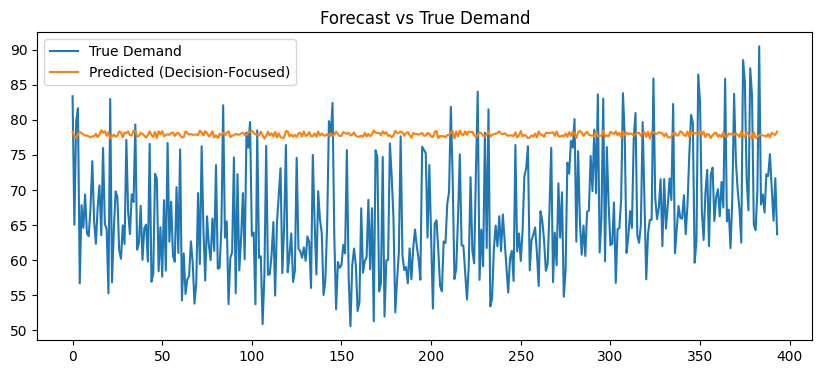

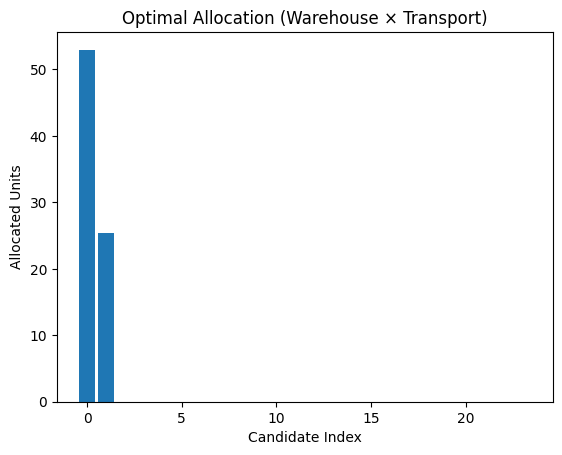

✅ Training Complete — Decision-Focused + MSE pretraining successful!


In [ ]:
# ================================================================
# 6️⃣ EVALUATION
# ================================================================
forecaster.eval()
with torch.no_grad():
    preds = torch.nn.functional.softplus(forecaster(X_test)) * y_std + y_mean

plt.figure(figsize=(10,4))
plt.plot(y_test.cpu() * y_std + y_mean, label="True Demand")
plt.plot(preds.cpu(), label="Predicted (Decision-Focused)")
plt.legend(); plt.title("Forecast vs True Demand")
plt.show()

# Example allocation
c_sample = gen_costs(1).squeeze(0)
cap_sample = gen_caps(1).squeeze(0)
d_sample = preds[0:1]
x_sol, = qp_layer(c_sample, d_sample, cap_sample)

plt.bar(range(n_candidates), x_sol.detach().cpu().numpy())
plt.title("Optimal Allocation (Warehouse × Transport)")
plt.xlabel("Candidate Index"); plt.ylabel("Allocated Units")
plt.show()

print("✅ Training Complete — Decision-Focused + MSE pretraining successful!")